# YOLO (You Only Look Once) Implementation for Traffic Assesment

## Prerequisites

#### Installing python dependencies

In [1]:
!pip install -r requirements.txt

#### Importing required libraries

In [2]:
import os
import random

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.patches as patches
import configparser
import ast
from xml.dom import minidom

from src.data_generator import DataGenerator
from src.data_preview import DataPreview

from tensorflow.python.client import device_lib
print('Tensorflow version: {}'.format(tf.__version__))
print('GPU: {}'.format([x.name for x in device_lib.list_local_devices()]))

Tensorflow version: 2.1.0
GPU: ['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


#### Setting YOLO Parameters

In [3]:
with open('./config/classes.names') as class_file:
    LABELS = class_file.read().splitlines()


In [4]:
config = configparser.ConfigParser()
config.read('config/params.config')

IMAGE_W             = int(config['YOLO']['IMAGE_W'])
IMAGE_H             = int(config['YOLO']['IMAGE_H'])
GRID_W              = int(config['YOLO']['GRID_W'])
GRID_H              = int(config['YOLO']['GRID_H'])
BOXES               = int(config['YOLO']['BOXES'])
CLASSES             = int(config['YOLO']['CLASSES'])
MIN_SCORE           = float(config['YOLO']['MIN_SCORE'])
MIN_IOU             = float(config['YOLO']['MIN_IOU'])
ANCHORS             = ast.literal_eval(config['YOLO']['ANCHORS'])

TRAIN_BATCH_SIZE    = int(config['TRAINING']['TRAIN_BATCH_SIZE'])
VAL_BATCH_SIZE      = int(config['TRAINING']['VAL_BATCH_SIZE'])
EPOCHS              = int(config['TRAINING']['EPOCHS'])

IMAGE_FOLDER        = config['DIR']['IMAGES']
ANNOTATION_FOLDER   = config['DIR']['ANNOTATIONS']

## Loading training/validation datasets

In [5]:
dataset = DataGenerator.generate_tf_dataset(
    ANNOTATION_FOLDER,
    IMAGE_FOLDER,
    LABELS,
    TRAIN_BATCH_SIZE,
    (IMAGE_W, IMAGE_H))

dataset

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 2)), types: (tf.float32, tf.int32)>

In [8]:
for i in range(5):
    DataPreview.preview_dataset(dataset, 0)

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

In [12]:
dataset = DataGenerator.augment_dataset(
    dataset,
    (IMAGE_W, IMAGE_H))

<generator object DataGenerator.augment_dataset at 0x7f85db5e6f68>

#### Testing whether the images & objects are loaded properly

In [24]:
plt.figure()
for i in range(0, 5):
    rng = random.randint(1, len(train_images))
    fig, ax = plt.subplots(1)
    ax.imshow(train_images[rng].image)
    
    for object in train_images[rng].objects:
        rect = patches.Rectangle(
            (object.bbox_corner(min)),
            object.bbox_corner(max)[0] - object.bbox_corner(min)[0],
            object.bbox_corner(max)[1] - object.bbox_corner(min)[1],
            linewidth=2,
            edgecolor='#ff0000',
            facecolor='none'
        )
        ax.add_patch(rect)
        
    print(train_images[rng].to_printable())
    plt.show()

NameError: name 'train_images' is not defined

## Defining and training the neural network

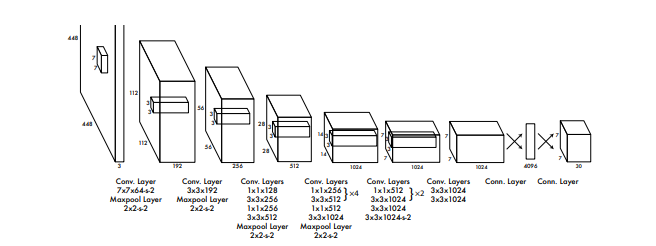

In [5]:

model = models.Sequential([
    # (512, 512, 3) -> conv_0 + norm_0 + relu_0 + max_pool_0 -> (256, 256, 32)
    layers.Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(512, 512, 3)),
    layers.BatchNormalization(input_shape=(512, 512, 32)),
    layers.LeakyReLU(alpha=0.1, input_shape=(512, 512, 32)),
    layers.MaxPooling2D(pool_size=(2, 2), input_shape=(512, 512, 32)),


    # (256, 256, 32) -> conv_1 + norm_1 + relu_1 + max_pool_1 -> (128, 128, 64)
    layers.Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(256, 256, 32)),
    layers.BatchNormalization(input_shape=(256, 256, 64)),
    layers.LeakyReLU(alpha=0.1, input_shape=(256, 256, 64)),
    layers.MaxPooling2D(pool_size=(2, 2), input_shape=(256, 256, 64)),


    # (128, 128, 64) -> conv_2 + norm_2 + relu_2 -> (128, 128, 128)
    layers.Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(128, 128, 128)),
    layers.BatchNormalization(input_shape=(128, 128, 128)),
    layers.LeakyReLU(alpha=0.1, input_shape=(128, 128, 128)),

    # (128, 128, 128) -> conv_3 + norm_3 + relu_3 -> (128, 128, 64)
    layers.Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(128, 128, 32)),
    layers.BatchNormalization(input_shape=(128, 128, 64)),
    layers.LeakyReLU(alpha=0.1, input_shape=(128, 128, 64)),

    # (128, 128, 64) -> conv_4 + norm_4 + relu_4 + max_pool_2 -> (64, 64, 128)
    layers.Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(128, 128, 64)),
    layers.BatchNormalization(input_shape=(128, 128, 128)),
    layers.LeakyReLU(alpha=0.1, input_shape=(128, 128, 128)),
    layers.MaxPooling2D(pool_size=(2, 2), input_shape=(128, 128, 128)),


    # (64, 64, 128) -> conv_5 + norm_5 + relu_5 -> (64, 64, 256)
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(64, 64, 128)),
    layers.BatchNormalization(input_shape=(64, 64, 256)),
    layers.LeakyReLU(alpha=0.1, input_shape=(64, 64, 256)),

    # (64, 64, 256) -> conv_6 + norm_6 + relu_6 -> (64, 64, 128)
    layers.Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(64, 64, 256)),
    layers.BatchNormalization(input_shape=(64, 64, 128)),
    layers.LeakyReLU(alpha=0.1, input_shape=(64, 64, 128)),

    # (64, 64, 128) -> conv_7 + norm_7 + relu_7 + max_pool_3 -> (32, 32, 256)
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(64, 64, 128)),
    layers.BatchNormalization(input_shape=(64, 64, 256)),
    layers.LeakyReLU(alpha=0.1, input_shape=(64, 64, 256)),
    layers.MaxPooling2D(pool_size=(2, 2), input_shape=(64, 64, 256)),


    # (32, 32, 256) -> conv_8 + norm_8 + relu_8 -> (32, 32, 512)
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(32, 32, 256)),
    layers.BatchNormalization(input_shape=(32, 32, 512)),
    layers.LeakyReLU(alpha=0.1, input_shape=(32, 32, 512)),

    # (32, 32, 512) -> conv_9 + norm_9 + relu_9 -> (32, 32, 256)
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(32, 32, 512)),
    layers.BatchNormalization(input_shape=(32, 32, 256)),
    layers.LeakyReLU(alpha=0.1, input_shape=(32, 32, 256)),

    # (32, 32, 256) -> conv_10 + norm_10 + relu_10 -> (32, 32, 512)
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(32, 32, 256)),
    layers.BatchNormalization(input_shape=(32, 32, 512)),
    layers.LeakyReLU(alpha=0.1, input_shape=(32, 32, 512)),

    # (32, 32, 512) -> conv_11 + norm_11 + relu_11 -> (32, 32, 256)
    layers.Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(32, 32, 512)),
    layers.BatchNormalization(input_shape=(32, 32, 256)),
    layers.LeakyReLU(alpha=0.1, input_shape=(32, 32, 256)),

    # (32, 32, 256) -> conv_12 + norm_12 + relu_12 + max_pool_4 -> (16, 16, 512)
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(32, 32, 256)),
    layers.BatchNormalization(input_shape=(32, 32, 512)),
    layers.LeakyReLU(alpha=0.1, input_shape=(32, 32, 512)),
    layers.MaxPooling2D(pool_size=(2, 2), input_shape=(32, 32, 512)),


    # (16, 16, 512) -> conv_13 + norm_13 + relu_13 -> (16, 16, 1024)
    layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 512)),
    layers.BatchNormalization(input_shape=(16, 16, 1024)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 1024)),

    # (16, 16, 1024) -> conv_14 + norm_14 + relu_14 -> (16, 16, 512)
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 1024)),
    layers.BatchNormalization(input_shape=(16, 16, 512)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 512)),

    # (16, 16, 512) -> conv_15 + norm_15 + relu_15 -> (16, 16, 1024)
    layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 512)),
    layers.BatchNormalization(input_shape=(16, 16, 1024)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 1024)),

    # (16, 16, 1024) -> conv_16 + norm_16 + relu_16 -> (16, 16, 512)
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 1024)),
    layers.BatchNormalization(input_shape=(16, 16, 512)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 512)),

    # (16, 16, 512) -> conv_17 + norm_17 + relu_17 -> (16, 16, 1024)
    layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 512)),
    layers.BatchNormalization(input_shape=(16, 16, 1024)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 1024)),

    # (16, 16, 1024) -> conv_18 + norm_18 + relu_18 -> (16, 16, 512)
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 1024)),
    layers.BatchNormalization(input_shape=(16, 16, 512)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 512)),

    # (16, 16, 512) -> conv_19 + norm_19 + relu_19 -> (16, 16, 1024)
    layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 512)),
    layers.BatchNormalization(input_shape=(16, 16, 1024)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 1024)),


    # (16, 16, 1024) -> conv_20 + norm_20 + relu_20 + dropout -> (16, 16, 1024)
    layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(16, 16, 1024)),
    layers.BatchNormalization(input_shape=(16, 16, 1024)),
    layers.LeakyReLU(alpha=0.1, input_shape=(16, 16, 1024)),
    layers.Dropout(0.3, input_shape=(16, 16, 1024)),

    # (16, 16, 1024) -> output_layer -> (16, 16, 5, 12)
    layers.Conv2D(BOXES * (5 + CLASSES), (1,1), strides=(1,1), padding='same'),
    layers.Reshape((GRID_W, GRID_H, BOXES, 5 + CLASSES))
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512, 512, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0

In [27]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

NameError: name 'model' is not defined

In [28]:
checkpoint_path = "train_checkpont/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

p_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [29]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

NameError: name 'train_images' is not defined

In [30]:
train_labels[0]

NameError: name 'train_labels' is not defined

In [31]:
detector = model.fit(
    train_images, train_labels, epochs=10, 
    validation_data=(
        val_images,
        val_labels)
)

NameError: name 'model' is not defined